# STTMALST Gastrointestinal-Cancer-MSI-MSS-Prediction

**Project created and conducted by: Christopher Bernold and Ellen Huld Þórðardóttir**

_Fall 2020_

Reference list and inspriation links:<br>

https://www.tensorflow.org/tutorials/load_data/images<br>
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#top_of_page  <br>
https://www.tensorflow.org/tutorials/images/classification<br>


In [83]:
#inspired by https://www.tensorflow.org/tutorials/load_data/images
%load_ext tensorboard
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import PIL
import PIL.Image
import tensorflow as tf
import datetime
import tensorflow_datasets as tfds
from tensorflow.python.client import device_lib
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, MaxPool2D, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
import pathlib 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [84]:
#Globals
batch_size = 32
epochs = 20
img_height_resized, img_width_resized = 28,28

Specifying tensorflow to use a GPU but only allocate memory from GPU when needed. 

_Currently broken as tensorflow does not always detect NVIDIA RTX GPU's, searching for solution._

In [85]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.compat.v1.Session
print("Tensorflow version: ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print(device_lib.list_local_devices())

Tensorflow version:  2.5.0-dev20201217
Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18351971296576295158
]


## Setting up the data 

In [86]:
DATA_PATH = './tcga_coad_msi_mss'
data_dir = pathlib.Path(DATA_PATH)

In [87]:
#Gets all images in all dataset folders
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print("Total amount of images is: ", image_count)

Total amount of images is:  192312


In [88]:
train_MSS, train_MSIMUT = list(data_dir.glob('train/MSS/*')), list(data_dir.glob('train/MSIMUT/*'))
test_MSS, test_MSIMUT = list(data_dir.glob('test/MSS/*')), list(data_dir.glob('test/MSIMUT/*'))
val_MSS, val_MSIMUT  = list(data_dir.glob('val/MSS/*')), list(data_dir.glob('val/MSIMUT/*'))

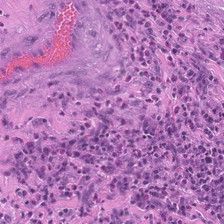

In [89]:
PIL.Image.open(str(train_MSS[0]))

In [90]:
image_details = PIL.Image.open(str(train_MSIMUT[0]))
width, height = image_details.size
print("Width:" , width , ", Height:" , height , ", Batch size:" , batch_size)

Width: 224 , Height: 224 , Batch size: 32


Specifying dataset folder locations. Data is already split up into train test and validation set, <br>
 meaning that we do not need to create a 80/20 split for the training and validation set.

In [91]:
training_set_dir = os.path.join(DATA_PATH, 'train')
training_root = pathlib.Path(training_set_dir)

test_set_dir = os.path.join(DATA_PATH, 'test')
test_root = pathlib.Path(test_set_dir)

validation_set_dir = os.path.join(DATA_PATH,'val')
validation_root = pathlib.Path(validation_set_dir)

train_MSIMUT_dir = os.path.join(training_set_dir, 'MSIMUT')
train_MSS_dir = os.path.join(training_set_dir, 'MSS')

test_MSIMUT_dir = os.path.join(test_set_dir, 'MSIMUT')
test_MSS_dir = os.path.join(test_set_dir, 'MSS')

validation_MSIMUT_dir = os.path.join(validation_set_dir, 'MSIMUT')
validation_MSS_dir = os.path.join(validation_set_dir, 'MSS')

In [92]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(training_root,
 seed=43110,
  image_size=(height,width),
   batch_size=batch_size,
    shuffle=True,
     color_mode='grayscale')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_root,
 seed=43110,
  image_size=(height,width),
   batch_size=batch_size,
    shuffle=True,
     color_mode='grayscale')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(validation_root,
 seed=43110,
  image_size=(height,width),
   batch_size=batch_size,
    shuffle=True,
     color_mode='grayscale')

Found 153849 files belonging to 2 classes.
Found 19233 files belonging to 2 classes.
Found 19230 files belonging to 2 classes.


In [93]:
class_names = train_ds.class_names
print(class_names)

['MSIMUT', 'MSS']


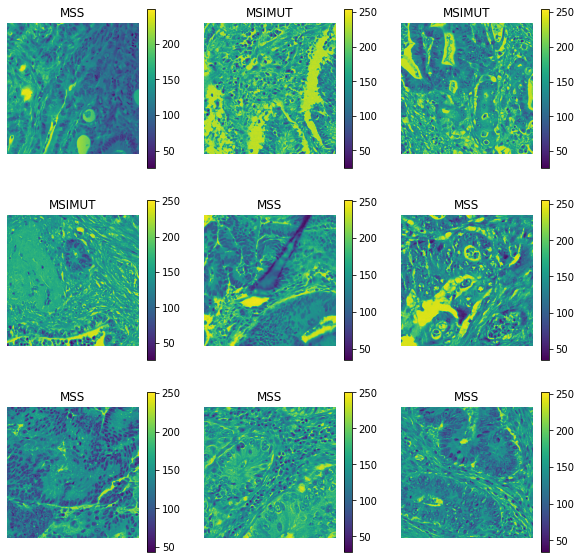

In [94]:
#Takes 9 random images from training set displaying MSS and MSIMUT images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.colorbar()
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [95]:
#Shape is 224(height)x(width)x1(RGB color channels == greyscale)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 1)
(32,)


In [96]:
image_batch_numpy = image_batch.numpy()
labels_batch_numpy = labels_batch.numpy()
print('Training data: Minimum RGB value for batch: %.3f, Maximum RGB value: %.3f' % (image_batch_numpy.min(), image_batch_numpy.max()))


Training data: Minimum RGB value for batch: 6.000, Maximum RGB value: 255.000


****
**Normalizing the data**
****

In [97]:
rgb_normalization = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_training_ds = train_ds.map(lambda x, y:(rgb_normalization(x), y))
image_batch, labels_batch = next(iter(normalized_training_ds))

In [98]:
print('Training data: Minimum RGB value for batch: %.3f, Maximum RGB value: %.3f' % (image_batch.numpy().min(), image_batch.numpy().max()))

Training data: Minimum RGB value for batch: 0.000, Maximum RGB value: 1.000


In [99]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [100]:
#Checking the shape of the labels and image data (X_train, y_train) to ensure everything is correct.
print("image_batch shape: ", image_batch.shape)
print("labels_batch shape: ", labels_batch.shape)


image_batch shape:  (32, 224, 224, 1)
labels_batch shape:  (32,)


When using categorical data it is wise to use one hot encoding. This is because when working with machine learning,<br>
 algorithms cannot use a labels string value directly, but instead requires all input and output values to instead be numeric values.<br>
 Here there are two typical ways of converting the categorical data into numeric data; integer encoding or One-Hot Encoding.<br>
 Integer encoding simply assigns each category an integer value e.g. MSIMUT would be assigned 1 and MSS would be assigned as 2. <br>
 One-Hot Encoding is one step above Integer encoding. Here categorical values are mapped to integer based values as with integer encoding,<br>
 each value is then represented as a binary vector containing zeros in every space other than the index of the integer which is marked as one.<br>
 Using one-hot encoding might be a little overkill in the project, but is still used as it is often very beneficial compared to integer encoding.<br>

 _references:_<br>

 https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
 
 https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In [101]:
labels_batch = tf.keras.utils.to_categorical(labels_batch, 2)

## Training the model

In [102]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(width, height, 1)))
#Convolutions
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

#Dropout to prevent overfitting
model.add(Dropout(0.25))
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
#pooling layer to reduce amount of parameters and computation in the network
model.add(MaxPool2D())
model.add(Dropout(0.20))
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(Dropout(0.20))
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
                 
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(Dropout(0.20))
model.add(MaxPool2D())
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))                 
model.add(MaxPool2D())
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
                 
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(Dropout(0.20))
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
                 
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(Dropout(0.20))
model.add(MaxPool2D())
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
                 
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(Dropout(0.20))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_18 (Rescaling)     (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 224, 224, 20)      200       
_________________________________________________________________
dropout_48 (Dropout)         (None, 224, 224, 20)      0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 224, 224, 20)      3620      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 112, 112, 20)      0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 112, 112, 20)      0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 112, 112, 20)    

In [103]:
#Tensorboard logging information
tensorboard = TensorBoard(
    log_dir = r'logs\{}'.format('cnn'),
    write_graph=True,
    write_grads=True,
    histogram_freq=1,
    write_images = True,
)

In [104]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [106]:
#Train the model
trained = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
  17/4808 [..............................] - ETA: 2:23:51 - loss: 1.6508 - accuracy: 0.4491

KeyboardInterrupt: 

DO NOT RUN CELL BELOW UNLESS NEEDED!!!

In [82]:
# for x, y in train_ds:
#     X_train = images.numpy()
#     y_train = labels.numpy()

In [83]:
# print('Training data: Minimum RGB value: %.3f, Maximum RGB value: %.3f' % (X_train.min(), X_train.max()))